In [1]:
#v10

In [2]:
from IPython.display import HTML
from IPython.display import display, HTML
from PIL import Image
from dask.distributed import Client
from dask.distributed import as_completed
from datetime import datetime
from dateutil.relativedelta import relativedelta
from matplotlib.dates import DateFormatter
from pandas.io.formats.style import Styler
from pivottablejs import pivot_ui
from pmdarima.arima import auto_arima
from scipy import stats
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
import re
from statsmodels.stats.outliers_influence import summary_table
import datetime as dt
import matplotlib
import matplotlib as mp
import matplotlib as mpl
import matplotlib.dates as md
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pandas_market_calendars as mcal
import pickle
import rpy2
import seaborn as sns
import sqlite3
import statsmodels.api as sm
import warnings
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import statsmodels
from statsmodels.tsa.exponential_smoothing.ets import ETSModel

pd.options.display.max_columns = 50
pd.options.display.max_rows = 200

import pandas as pd
from prophet import Prophet

C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
si = ['03-31','06-30','09-30','12-31']

               
[start,end,prices_df, sp1500_index_df, sp500, sp600, sp400, market_data, completed_fred_pvt, completed_bonds, completed_bonds_pvt, sectors, indexes, screener_sorted, dict_sectors, dict_indexes, dict_sectors_reverse, invert_dict_indexes, list_sector_n_indexes, list_stocks] = pickle.load(open('./data_object.pkl', 'rb'))

nyse = mcal.get_calendar('NYSE')
nyse_dates = nyse.schedule(start_date=start, end_date=end)

fundamentals_quarterlies = pickle.load(open('./fundamental.pkl', 'rb'))
fundamental_entries = [e[0] for e in fundamentals_quarterlies]

sectors.columns = ['Symbol']
indexes.columns = ['Symbol']

newDates = pd.date_range((end+ dt.timedelta(7)).strftime('%Y-%m-%d'), (end + dt.timedelta(92)).strftime('%Y-%m-%d'), freq='W-'+nyse_dates.index[-1].strftime('%a')).map(lambda t: t.strftime('%Y-%m-%d'))

db_filename = 'todo.db'

db_is_new = not os.path.exists(db_filename)

conn = sqlite3.connect(db_filename)

if db_is_new:
    print('Need to create schema')
else:
    print('Database exists, assume schema does, too.')

conn.close()

Database exists, assume schema does, too.


In [4]:
def evaluate_ets(npa_):
    train,test,model_func,flag_ = npa_
    
    #try:
    if(len(flag_)==2):
        if(flag_[1] is None):
            model = model_func(np.log(train['Adj Close']),initialization_method='heuristic',seasonal=flag_[0],trend=flag_[1],dates=train.index).fit()
        else:
            model = model_func(np.log(train['Adj Close']),initialization_method='heuristic',seasonal=flag_[0],seasonal_periods=52,trend=flag_[1],dates=train.index).fit()
    else:
        model = model_func(np.log(train['Adj Close']),initialization_method='heuristic',seasonal=flag_[0],seasonal_periods=52,trend=flag_[1],damped_trend=flag_[2],dates=train.index).fit()

    fc_ets_ = np.exp(model.get_prediction(start=test.index[0],end=test.index[-1]).summary_frame())
    rmse_ = mean_squared_error(test, fc_ets_['mean'], squared=True)
    #except:
        #not enough data points
        #rmse_ = np.nan
    
    return([flag_,rmse_])

In [5]:
def time_to_int(dateobj):
    total = int(dateobj.strftime('%S'))
    total += int(dateobj.strftime('%M')) * 60
    total += int(dateobj.strftime('%H')) * 60 * 60
    total += (int(dateobj.strftime('%j')) - 1) * 60 * 60 * 24
    total += (int(dateobj.strftime('%Y')) - 1970) * 60 * 60 * 24 * 365
    return total


In [6]:
def highlight_cells(val, color_if_true, color_if_false, threshold_):
    color = color_if_true if val >= threshold_ else color_if_false
    return 'background-color: {}'.format(color)

In [7]:
def evaluate_prophet(npa_):
    train,test = npa_

    m = Prophet()

    temp_train = train.reset_index()
    temp_train.iloc[:,1] = np.log(temp_train.iloc[:,1])
    temp_train.columns = ['ds','y']

    m.fit(temp_train)
    future = m.make_future_dataframe(periods=13,freq='W-'+nyse_dates.index[-1].strftime('%a'))

    forecast = m.predict(future.tail(13))
    #forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
    rmse_ = mean_squared_error(test, np.exp(forecast[['yhat']]).tail(13), squared=True)
    #print(rmse_)
    return(rmse_)


In [8]:
def derive_test_error(npa):
    n_ahead = 13

    subset_train = npa[0]
    subset_test = npa[1]

    base_model = Prophet()

    prophet_df_base = subset_train['Adj Close'].reset_index()#data.reset_index()
    prophet_df_base.columns = ['ds','y']
    prophet_df_base['y'] = np.log(prophet_df_base['y'])

    base_model.fit(prophet_df_base)

    future_base = base_model.make_future_dataframe(periods = n_ahead,freq='W-'+subset_train.index[-1].strftime('%a'))

    forecast_base = base_model.predict(future_base).set_index('ds')[['yhat','yhat_lower','yhat_upper']]
    df_pred_base = np.exp(forecast_base)

    #sum_of_test_er = np.sum((subset_test['Adj Close'].tail(n_ahead)-df_pred_base['yhat'].tail(n_ahead))**2)
    #test_std = np.sqrt(1/(len(subset_test['Adj Close'].tail(n_ahead))-2) * sum_of_test_er)
    test_error = (subset_test['Adj Close'].tail(n_ahead)-df_pred_base['yhat'].tail(n_ahead))
    return(test_error)

In [9]:
"""
for r in range(0,len(test_errors)):
    pd.DataFrame([t[r] for t in test_errors]).hist()
    plt.show()
"""

'\nfor r in range(0,len(test_errors)):\n    pd.DataFrame([t[r] for t in test_errors]).hist()\n    plt.show()\n'

In [10]:

def plot_(symbol_):

    #def plot_(symbol_):
    #symbol_ = 'FCN'
    print(symbol_)
    print(type(symbol_))
    print(str(symbol_))
    if(str(symbol_)=='None'):
        run=False
    else:
        run=True

    if(run):
        client = Client('192.168.3.100:8786')
        #client = Client(n_workers=4,threads_per_worker=1)

        s = symbol_
        #for s in ['CEIX']:
        msize = 2
        date_form = DateFormatter("%Y-%m-%d")

        metrics_df_ = pd.DataFrame(pd.DataFrame(screener_sorted.loc[s]).T[['volume_factor','Adj Close','adf','hurst']])

        subset=prices_df[prices_df['Symbol']==s]

        dates = []
        for t in subset.index.values:
            d = pd.Timestamp(t).strftime('%Y-%m-%d')
            dates.append(d)
            dto = datetime.strptime(d, '%Y-%m-%d').date()

        old_ordinal = [datetime.strptime(i, '%Y-%m-%d').toordinal() for i in dates]
        new_ordinal = old_ordinal + md.date2num(np.datetime64('0000-12-31'))
        x = new_ordinal    

        lookup_index_ = []

        labels = list()
        print("symbol:",s)   

        symbol_sector = screener_sorted.loc[symbol_]['Sector Symbol']
        """
        try:
            symbol_sector = dict_sectors[sector_merged[sector_merged['Symbol']==s]['Sector'].values[0]]
            symbol_sector = screener_sorted.loc[symbol_]['Sector']
            print("sector:",dict_sectors_reverse[symbol_sector])
        except:
            symbol_sector=='error'
        """
        """
        if(symbol_sector=='error'):
            if(np.sum([sectors['Symbol'].values==s])):
                symbol_sector = s
                print("sector:",dict_sectors_reverse[symbol_sector])
        #else:
            symbol_sector = 'error'
            print("sector:",'error')
        """
        print("sector:",dict_sectors_reverse[symbol_sector])
        symbol_index = screener_sorted.loc[s]['Index Symbol']

        try:
            matched_index_name = indexes.iloc[np.where(indexes['Symbol'].values==s)].index[0]
        except:
            try:
                matched_index_name = screener_sorted.loc[s]['Index Symbol']
            except:
                matched_index_name = "error"

        print("Index:",dict_indexes[matched_index_name])

        print("Volume Factor:",screener_sorted.iloc[np.where(screener_sorted.index==s)]['volume_factor'][0])
        #print("1YMF:",subset['1YMF'].values[-1])
        print("sector_risk_trend_factor:",screener_sorted[screener_sorted.index==s]['sector_risk_trend_factor'][0])
        print("risk trend factor:",screener_sorted.iloc[np.where(screener_sorted.index==s)]['risk_trend_factor'][0])

        temp = pd.DataFrame(market_data.loc[s])
        print(temp[np.array(temp!='error')].replace([np.inf,'inf','error', -np.inf], np.nan).dropna().T)

        last_date = pd.DataFrame(subset.iloc[-1][['21dBOLD','21dMA-TP','21dBOLU']],index=[prices_df[prices_df['Symbol']==s].index[-1].strftime('%Y-%m-%d')]).index[0]

        bbands = pd.DataFrame(subset.iloc[-1][['Adj Close','21dBOLD','21dMA-TP','21dBOLU','90dSMA','90dSDev']]).T
        bbands['90d_lower'] = bbands['90dSMA']-bbands['90dSDev']*2
        bbands['90d_upper'] = bbands['90dSMA']+bbands['90dSDev']*2

        bbands.index = [last_date]
        display(bbands)

        display(metrics_df_)

        mean_revert_flag = False

        if(metrics_df_['adf'][0]<.05):
            print("ADFuller H0 rejected @ .05, Mean Reverting TS")
            if(bbands['Adj Close'][0]<bbands['90d_lower'][0]):
                colored_text = colored(255, 0, 0, "Quarter Mean Reverting buy signal")
                print(colored_text)
                mean_revert_flag = True
            if(bbands['Adj Close'][0]<bbands['21dBOLU'][0]):
                colored_text = colored(255, 0, 0, "Month Mean Reverting buy signal")
                print(colored_text)
                mean_revert_flag = True    

        l_axis_legend = pd.DataFrame(['symbol', 'trailing_1yr_max', 'trailing_1yr_min', '30d_vol_2yr','risk_trend_factor/linear','supply_trend_1yr'],index=['blue','green','red','orange','black','yellow'],columns=['legend'])

        r_axis_legend = pd.DataFrame(['sector','index'],index=['magenta','cyan'],columns=['legend'])

        display_side_by_side([l_axis_legend, r_axis_legend], ['l axis', 'r axis'])        

        f, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, sharey=False,figsize=(22,5))
        ax1.plot(subset['30d_vol_2yr'],color='orange')
        #plt.title('30d_vol_2yr')
        ax1.set_xticklabels(subset[['30d_vol_2yr']].dropna().index, rotation = 45)

        locator = matplotlib.dates.AutoDateLocator()
        formatter = matplotlib.dates.ConciseDateFormatter(locator)

        ax1.xaxis.set_major_locator(locator)
        ax1.xaxis.set_major_formatter(formatter)

        ax1.xaxis.set_major_formatter(date_form)

        #plt.title('30d_vol_2yr')
        ax2.plot(subset['risk_trend_factor'],color='black')
        #plt.title('risk_trend_factor')
        ax2.set_xticklabels(subset[['risk_trend_factor']].dropna().index, rotation = 45)

        locator = matplotlib.dates.AutoDateLocator()
        formatter = matplotlib.dates.ConciseDateFormatter(locator)

        ax2.xaxis.set_major_locator(locator)
        ax2.xaxis.set_major_formatter(formatter)

        ax2.xaxis.set_major_formatter(date_form)
        #plt.title('risk_trend_factor')

        #fig, ax1 = plt.subplots()   

        ax3_ = ax3.twinx()
        ax5_ = ax5.twinx()        
        ax4_ = ax4.twinx()

        y = subset['Adj Close']

        def myfunc(x):
            return slope * x + intercept

        slope, intercept, r, p, std_err = stats.linregress(x, y)

        mymodel = list(map(myfunc, x))

        ax3.plot(x, y,marker = '.',markersize=msize, color = 'b')
        ax3.plot(x, subset['trailing_1yr_max'],marker = '.',markersize=msize, color = 'g')
        ax3.plot(x, subset['trailing_1yr_min'],marker = '.',markersize=msize, color = 'r')
        #ax1.plot(x, subset['risk_trend_factor'],marker = '.',markersize=msize, color = 'orange')

        ax3_.plot(x, subset['supply_trend_1yr'],marker = '.',markersize=msize, color = 'y')

        ax3.plot(x, mymodel, color = 'k')
        """
        try:
            ax5.plot(x, y,marker = '.',markersize=msize, color = 'b')
            ax5.plot(x, subset['trailing_1yr_max'],marker = '.',markersize=msize, color = 'g')
            ax5.plot(x, subset['trailing_1yr_min'],marker = '.',markersize=msize, color = 'r')
            #ax1.plot(x, subset['risk_trend_factor'],marker = '.',markersize=msize, color = 'orange')

            ax5_.plot(x, subset['supply_trend_1yr'],marker = '.',markersize=msize, color = 'y')

            ax5.plot(x, mymodel, color = 'k')
        except:
            pass
        """
        #for l in ['symbol','1yrMax','1yrMin','risk_trend_factor','supply_trend_1yr','linear']:
            #labels.append(l)

        l = matplotlib.dates.AutoDateLocator()
        f = matplotlib.dates.ConciseDateFormatter(l)    

        ax3.set_xticklabels(ax3.get_xticks(), rotation = 45)

        locator = matplotlib.dates.AutoDateLocator()
        formatter = matplotlib.dates.ConciseDateFormatter(locator)

        ax3.xaxis.set_major_locator(locator)
        ax3.xaxis.set_major_formatter(formatter)

        ax3.xaxis.set_major_formatter(date_form)

        if(symbol_sector=='error'):
            pass
        else:
            if(np.sum(sectors['Symbol'].values==s)>0):
                pass
            else:
                sector_subset = prices_df[prices_df['Symbol']==symbol_sector]
                #print("sector",)
                #print("else_sector:",dict_sectors_reverse[s])            
                #print("Sector 1YMF:",screener_sorted[screener_sorted.index==symbol_sector]['risk_trend_factor'][0])
                print("Sector Volume Factor:",screener_sorted.iloc[np.where(screener_sorted.index==symbol_sector)]['volume_factor'][0])
                print("Sector Risk Trend Factor:",screener_sorted.iloc[np.where(screener_sorted.index==symbol_sector)]['risk_trend_factor'][0])
                #ax3_.plot(x, (sector_subset['Adj Close']).iloc[-len(subset):],marker = '.',markersize=msize,color='m',linestyle=(0, (3, 10, 1, 10)))
                ax4.plot(x, (sector_subset['Adj Close']).iloc[-len(subset):],marker = '.',markersize=msize,color='m',linestyle=(0, (3, 10, 1, 10)))
                ax4.plot(x, (sector_subset['trailing_1yr_max']).iloc[-len(subset):],marker = '.',markersize=msize, color = 'g')
                ax4.plot(x, (sector_subset['trailing_1yr_min']).iloc[-len(subset):],marker = '.',markersize=msize, color = 'r')
                ax4_.plot(x, (sector_subset['supply_trend_1yr']).iloc[-len(subset):],marker = '.',markersize=msize,color='y',linestyle=(0, (3, 10, 1, 10)))

                ax4.set_xticklabels(subset.dropna().index, rotation = 45)
                ax4.xaxis.set_major_formatter(date_form)

                #ax2.plot(x, prices_df[prices_df['Symbol']==symbol_sector]['Adj Close'],marker = '.',markersize=msize,color='m',linestyle=(0, (3, 10, 1, 10)))        
                #plt.legend([screener_sorted.loc[s]['Sector']])
                #labels_ax2.append(screener_sorted.loc[s]['Sector'])
                #plt.show()

        if(str(screener_sorted.loc[s]['Index Symbol'])!='nan'):
            if(screener_sorted.loc[s]['Index Symbol']!='error'):
                index_subset = prices_df[prices_df['Symbol']==screener_sorted.loc[s]['Index Symbol']]
                #print(screener_sorted.loc[s]['Index Symbol'])
                #print("Index 1YMF:",screener_sorted[screener_sorted.index==screener_sorted.loc[s]['Index Symbol']]['risk_trend_factor'][0])
                print("Index Volume Factor:",screener_sorted.iloc[np.where(screener_sorted.index==screener_sorted.loc[s]['Index Symbol'])]['volume_factor'][0])
                print("Index Risk Trend Factor:",screener_sorted.iloc[np.where(screener_sorted.index==screener_sorted.loc[s]['Index Symbol'])]['risk_trend_factor'][0])
                #ax3_.plot(x, index_subset['Adj Close'].iloc[-len(subset):],marker = '.',markersize=msize,color='c',linestyle=(0, (1, 10)))
                ax5.plot(x, index_subset['Adj Close'].iloc[-len(subset):],marker = '.',markersize=msize,color='c',linestyle=(0, (1, 10)))
                ax5.plot(x, index_subset['trailing_1yr_max'].iloc[-len(subset):],marker = '.',markersize=msize, color = 'g')
                ax5.plot(x, index_subset['trailing_1yr_min'].iloc[-len(subset):],marker = '.',markersize=msize, color = 'r')
                ax5_.plot(x, index_subset['supply_trend_1yr'].iloc[-len(subset):],marker = '.',markersize=msize,color='y',linestyle=(0, (1, 10)))

                ax5.set_xticklabels(index_subset.dropna().index, rotation = 45)
                ax5.xaxis.set_major_formatter(date_form)
                #plt.plot()
                #plt.legend([screener_sorted.loc[s]['index']])
                #labels_ax2.append(screener_sorted.loc[s]['index'])
                #plt.show()

        plt.show()

        print("ets next 13 weeks")

        #ets
        if(True):

            #take last nyse date and extrapolate weeks from that point
            #starting from next week
            newDates = pd.date_range((subset.index[-1] + dt.timedelta(7)).strftime('%Y-%m-%d'), (subset.index[-1] + dt.timedelta(92)).strftime('%Y-%m-%d'), freq='W-'+nyse_dates.index[-1].strftime('%a')).map(lambda t: t.strftime('%Y-%m-%d'))

            print(subset.index[-1].strftime('%Y-%m-%d'))
            print(newDates[0])
            #data = subset[['Adj Close']].asfreq('D').interpolate().asfreq('W-'+subset.index[-1].strftime('%a'))
            data = subset[['Adj Close']].asfreq('D').interpolate().asfreq('W-'+nyse_dates.index[-1].strftime('%a'))            

            #if(np.where(np.array(list__)==s)[0][0]%batchClearLimit==0):        
            #client.restart()

            cv_inner = TimeSeriesSplit(n_splits=11,test_size=13)

            #has to be different makeup than cv_inner because there is no randomization.  Recommend a number that isn't a divisor of cv_inner's n_splits to ensure training is mixed up and not aligned
            cv_outer = TimeSeriesSplit(n_splits=10,test_size=13)

            outer_results = []

            #sm.tsa.statespace.ExponentialSmoothing
            """
            flags = []
            seasonal_flags1 = ['add','mul',None]

            trend_flags2 = ['add','mul',None]

            damped__trend_flags3 = [True,False]

            for sf in seasonal_flags1:
                for dt_ in trend_flags2:
                    if(dt_ is None):          
                        for d_ in damped__trend_flags3:
                            flags.append([sf,dt_,d_])
            """


            flags = [['add', 'add', True],\
             ['add', 'add', False],\
             ['add', 'mul', True],\
             ['add', 'mul', False],\
             ['add', None],\
             ['mul', 'add', True],\
             ['mul', 'add', False],\
             ['mul', 'mul', True],\
             ['mul', 'mul', False],\
             ['mul', None],\
             [None, 'add', True],\
             [None, 'add', False],\
             [None, 'mul', True],\
             [None, 'mul', False],\
             [None, None]]

            #print(flags)

            #flags = [['T','T'],['T','F'],['F','F'],['F','T']]       

            rmse_inner_flags = []

            for flag in flags:
                #print(flag)

                npa = []

                for trainv_ix, test_ix in cv_inner.split(data.index):

                    npa.append([data.iloc[trainv_ix],data.iloc[test_ix],ETSModel,flag])

                #rmses_inner = []
                #rmses_inner
                #for n in npa:
                    #r = evaluate_ets(n)
                    #print(r)
                    #rmses_inner.append(r)
                future = client.map(evaluate_ets, npa)        

                rmses_inner = []
                #flag_order = []
                #my intent was to capture future objects vs results and this gave me results

                for f in as_completed(future):
                    #exclude errors
                    if(f.status=="error"):
                        #pass
                        #this causes errors with [flag,rmse] being passed by evaluate_ets
                        rmses_inner.append([flag,np.nan])
                    else:
                        rmses_inner.append(f.result())

                #I don't want to keep track of flag here
                #flag_order = [r[0] for r in results_rmses].copy()
                #print(rmses_inner)
                rmse_ = [r[1] for r in rmses_inner].copy()


                #print(rmse_)
                #print(flag)
                rmse_inner_flags.append([flag,np.nanmean(rmse_),np.nanstd(rmse_)])

            #rmse_scores = []
            #flag_rmses = []

            #for fn_ in range(0,len(flags)):
                #flag_ = flags[fn_]
                #rmse_scores.append([flag_rmses[fn_],rmses[fn_][1]])

            print("inner cv scores:")
            inner_rmse_df = pd.DataFrame(rmse_inner_flags,columns=['flags','mean','std'])
            #print("inner cv scores:",[r[rmses)
            #print("inner cv sdevs:",sdevs)

            scores = inner_rmse_df['mean'].values
            sdevs = inner_rmse_df['std'].values
            best_model = inner_rmse_df['flags'].values[np.argmin(scores)]

            print("best model:",best_model)
            print("best inner cv score, sdev (11 folds):",scores[np.argmin(scores)],sdevs[np.argmin(scores)])

            npa = []

            for trainv_ix, test_ix in cv_outer.split(data.index):

                npa.append([data.iloc[trainv_ix],data.iloc[test_ix],ETSModel,best_model])

            future = client.map(evaluate_ets, npa)
            results_rmses_outer = []

            #my intent was to capture future objects vs results and this gave me results
            for f in as_completed(future):
                #exclude errors
                if(f.status=="error"):
                    #pass
                    results_rmses_outer.append([np.nan])
                else:
                    results_rmses_outer.append(f.result()) 

            test_score_mean = np.nanmean([r[1] for r in results_rmses_outer])
            test_score_std = np.nanstd([r[1] for r in results_rmses_outer])

            #test_score = [np.nanmean(rmse_outer_df['mean'].values),np.nanstd(rmse_outer_df['mean'].values)]
            print("test cv mean error, stdev (10 folds):",test_score_mean,test_score_std)

            #final_model=ETSModel(np.log(data),initialization_method='heuristic',seasonal=52,trend=F1,damped_trend=F2).fit()    


            #final_model=ETSModel(np.log(data),initialization_method='heuristic',seasonal=52,trend=F1,damped_trend=F2).fit()    
            flag = best_model
            if(len(flag)==2):
                if(flag[1] is None):
                    final_model = ETSModel(np.log(data['Adj Close']),initialization_method='heuristic',seasonal=flag[0],trend=flag[1],dates=data.index).fit()
                else:
                    final_model = ETSModel(np.log(data['Adj Close']),initialization_method='heuristic',seasonal=flag[0],seasonal_periods=52,trend=flag[1],dates=data.index).fit()
            else:
                final_model = ETSModel(np.log(data['Adj Close']),initialization_method='heuristic',seasonal=flag[0],seasonal_periods=52,trend=flag[1],damped_trend=flag[2],dates=data.index).fit()

            try:

                df_pred = np.exp(final_model.get_prediction(start=data.index[0].strftime('%Y-%m-%d'),end=(end + dt.timedelta(92)).strftime('%Y-%m-%d')).summary_frame())

            except:
                try:
                    test = np.exp(pd.DataFrame(final_model.get_prediction(start=data.index[0].strftime('%Y-%m-%d'),end=(end + dt.timedelta(92)).strftime('%Y-%m-%d')).predicted_mean))
                    test.columns = ['mean']
                    df_pred = test
                except:
                    df_pred = pd.DataFrame(np.repeat(np.nan,13),columns=['mean'])
                    df_pred.index = [datetime.strptime(d, '%Y-%m-%d').date() for d in newDates] 

            #df_conf = np.exp(final_model.get_prediction(start=end,end=(end + dt.timedelta(92)).strftime('%Y-%m-%d')).pred_int(alpha = .05))
            #df_conf.columns = ['ci_lower','ci_upper']

            #final_model = ETSModel(np.log(data['Adj Close']),initialization_method='heuristic',seasonal=['add','mul','None'][0],seasonal_periods=52,trend=['add','mul','None'][0],damped_trend=['True','False'][0],dates=data.index).fit()
            #pred = final_model.get_prediction(start=end,end=(end + dt.timedelta(92)).strftime('%Y-%m-%d'))

            #final_model.get_prediction(start=end,end=(end + dt.timedelta(92)).strftime('%Y-%m-%d')).summary_frame()

            #df_pred = np.exp(pred.summary_frame(alpha=0.05))
            #df_pred = np.exp(pred.summary(alpha=0.05))

            s_date = df_pred.index[np.argmax(df_pred['mean'].values)].strftime('%Y-%m-%d')


            print("sell date:",s_date)
            e_return = np.array((np.max(df_pred['mean'].values)-metrics_df_['Adj Close'])/metrics_df_['Adj Close'])[0]
            p_metrics = pd.DataFrame(df_pred.iloc[np.argmax(df_pred['mean'].values)]).T
            #c_metrics = pd.DataFrame(df_conf.iloc[np.argmax(df_pred['mean'].values)]).T
            #print(c_metrics)
            print("expected return:",e_return)

            days_delta = (datetime.strptime(s_date, '%Y-%m-%d') - datetime.strptime(end.strftime('%Y-%m-%d'), '%Y-%m-%d')).days
            try:
                discounted_return = (1+e_return)**(1/days_delta)-1
            except:
                 discounted_return = 0
            qtr_return = (1+discounted_return)**92

            print("discounted return:",discounted_return)

            print("quarter return:",qtr_return)

            try:
                #used to help filter at the end, not sdevs is chosen based on min score
                stop_loss_price = pd.DataFrame(np.mean(np.exp(final_model.get_prediction(start=end,end=(end + dt.timedelta(92)).strftime('%Y-%m-%d')).summary_frame())[['mean','pi_lower']],axis=1)).iloc[0].values[0]
                #decision_metrics.append([s,e_return,s_date,stop_loss_price,days_delta,discounted_return,qtr_return,test_score_mean,test_score_std,mean_revert_flag,p_metrics['pi_lower'].values[0],p_metrics['pi_upper'].values[0]])
                decision_metrics_df = pd.DataFrame([s,e_return,s_date,stop_loss_price,days_delta,discounted_return,qtr_return,test_score_mean,test_score_std,mean_revert_flag,p_metrics['pi_lower'].values[0],p_metrics['pi_upper'].values[0]])#,columns=)#,index=[s_])#.sort_values(by='disc_rtn',ascending=False,inplace=True)
                decision_metrics_df = decision_metrics_df.T
                decision_metrics_df.columns=['SYMBOL','exp_return','sell_date','stop_loss_price','days_delta','disc_rtn','qtr_rtn','outer_cv_avg_rmse_n11','outer_cv_std_n11','mean_revert_flag','pi_lower','pi_upper']
                decision_metrics_df.index = [symbol_]
            except:
                #used to help filter at the end, not sdevs is chosen based on min score
                stop_loss_price = df_pred[['mean']].iloc[0].values[0]
                #decision_metrics.append([s,e_return,s_date,stop_loss_price,days_delta,discounted_return,qtr_return,test_score_mean,test_score_std,mean_revert_flag,p_metrics['pi_lower'].values[0],p_metrics['pi_upper'].values[0]])
                decision_metrics_df = pd.DataFrame([s,e_return,s_date,stop_loss_price,days_delta,discounted_return,qtr_return,test_score_mean,test_score_std,mean_revert_flag])#,columns=)#,index=[s_])#.sort_values(by='disc_rtn',ascending=False,inplace=True)
                decision_metrics_df = decision_metrics_df.T
                decision_metrics_df.columns=['SYMBOL','exp_return','sell_date','stop_loss_price','days_delta','disc_rtn','qtr_rtn','outer_cv_avg_rmse_n11','outer_cv_std_n11','mean_revert_flag']
                decision_metrics_df.index = [symbol_]

            print("Outer CV Error / Price Ratio",decision_metrics_df['outer_cv_avg_rmse_n11']/screener_sorted.loc[symbol_]['Adj Close'])
            print(" Outer CV StdDev / Price Ratio",decision_metrics_df['outer_cv_std_n11']/screener_sorted.loc[symbol_]['Adj Close'])

            #display(decision_metrics_df.style.applymap(highlight_cells, color_if_false='yellow', color_if_true='#C6E2E9', subset=['error_price_ratio','mean_revert_flag','std_price_ratio'], threshold_=.75))

            try:

                temp_price = data
                temp_price.columns = ['mean']
                plt.plot(temp_price)
                plt.plot(df_pred)
                #plt.xticks([*data.tail(13).index.map(lambda t: t.strftime('%Y-%m-%d')),*newDates],rotation = 45,size=8)
                plt.xticks(rotation = 45,size=8)
                plt.legend(['actual','mean prediction','pi_lower','pi_upper'],loc=2)
                plt.show()

                plt.plot(temp_price.tail(13))
                plt.plot(df_pred.tail(26))
                #plt.xticks([*data.tail(13).index.map(lambda t: t.strftime('%Y-%m-%d')),*newDates],rotation = 45,size=8)
                plt.xticks(rotation = 45,size=8)
                plt.legend(['actual','mean prediction','pi_lower','pi_upper'],loc=2)
                plt.show()
            except:

                temp_price = data
                temp_price.columns = ['mean']
                plt.plot(temp_price)
                plt.plot(df_pred)
                #plt.xticks([*data.tail(13).index.map(lambda t: t.strftime('%Y-%m-%d')),*newDates],rotation = 45,size=8)
                plt.xticks(rotation = 45,size=8)
                plt.legend(['actual','mean prediction'],loc=2)
                plt.show()

                plt.plot(temp_price.tail(13))
                plt.plot(df_pred.tail(26))
                #plt.xticks([*data.tail(13).index.map(lambda t: t.strftime('%Y-%m-%d')),*newDates],rotation = 45,size=8)
                plt.xticks(rotation = 45,size=8)
                plt.legend(['actual','mean prediction'],loc=2)
                plt.show()

            display(decision_metrics_df)

            #take last nyse date and extrapolate weeks from that point
            #starting from next week

            data = subset[['Adj Close']].asfreq('D').interpolate().asfreq('W-'+subset.index[-1].strftime('%a'))

            #calculate prediction interval

            client = Client('192.168.3.100:8786')

            npa = []
            for trainv_ix, test_ix in cv_outer.split(data.index):
                subset_train = data.iloc[trainv_ix]
                subset_test = data.iloc[test_ix]

                npa.append([subset_train,subset_test])

            future = client.map(derive_test_error, npa)        

            test_errors = []

            for f in as_completed(future):
                #exclude errors
                if(f.status=="error"):
                    test_errors.append(np.nan)
                else:
                    test_errors.append(f.result())

            std_error_test = np.std(test_errors,axis=0)

            #if(np.where(np.array(list__)==s)[0][0]%batchClearLimit==0):        
            #client.restart()

            cv_inner = TimeSeriesSplit(n_splits=11,test_size=13)

            #has to be different makeup than cv_inner because there is no randomization.  Recommend a number that isn't a divisor of cv_inner's n_splits to ensure training is mixed up and not aligned
            cv_outer = TimeSeriesSplit(n_splits=10,test_size=13)

            outer_results = []
            #print(flag)

            npa = []

            for trainv_ix, test_ix in cv_inner.split(data.index):

                npa.append([data.iloc[trainv_ix],data.iloc[test_ix]])

            #rmses_inner = []
            #rmses_inner
            #for n in npa:
                #r = evaluate_ets(n)
                #print(r)
                #rmses_inner.append(r)
            future = client.map(evaluate_prophet, npa)        

            rmses_inner = []
            #flag_order = []
            #my intent was to capture future objects vs results and this gave me results

            for f in as_completed(future):
                #exclude errors
                if(f.status=="error"):
                    #pass
                    #this causes errors with [flag,rmse] being passed by evaluate_ets
                    rmses_inner.append(np.nan)
                else:
                    rmses_inner.append(f.result())

            #I don't want to keep track of flag here
            #flag_order = [r[0] for r in results_rmses].copy()
            #print(rmses_inner)
            rmse_ = [r for r in rmses_inner].copy()

            #print(rmse_)
            #print(flag)
            rmse_inner_flags = [np.nanmean(rmse_),np.nanstd(rmse_)]

            #rmse_scores = []
            #flag_rmses = []

            #for fn_ in range(0,len(flags)):
                #flag_ = flags[fn_]
                #rmse_scores.append([flag_rmses[fn_],rmses[fn_][1]])

            print("inner cv scores:")
            inner_rmse_df = pd.DataFrame([rmse_inner_flags],columns=['mean','std'])
            #print("inner cv scores:",[r[rmses)
            #print("inner cv sdevs:",sdevs)

            scores = inner_rmse_df['mean'].values
            sdevs = inner_rmse_df['std'].values
            print("best inner cv score, sdev (11 folds):",scores[np.argmin(scores)],sdevs[np.argmin(scores)])

            npa = []

            for trainv_ix, test_ix in cv_outer.split(data.index):

                npa.append([data.iloc[trainv_ix],data.iloc[test_ix]])

            future = client.map(evaluate_prophet, npa)
            results_rmses_outer = []

            #my intent was to capture future objects vs results and this gave me results
            for f in as_completed(future):
                #exclude errors
                if(f.status=="error"):
                    #pass
                    results_rmses_outer.append([np.nan])
                else:
                    results_rmses_outer.append(f.result()) 

            test_score_mean = np.nanmean([r for r in results_rmses_outer])
            test_score_std = np.nanstd([r for r in results_rmses_outer])

            #test_score = [np.nanmean(rmse_outer_df['mean'].values),np.nanstd(rmse_outer_df['mean'].values)]
            print("test cv mean error, stdev (10 folds):",test_score_mean,test_score_std)

            """
            m = Prophet()

            prophet_df = data.reset_index()
            prophet_df.columns = ['ds','y']
            prophet_df['y'] = np.log(prophet_df['y'])
            m.fit(prophet_df)
            #m = Prophet(mcmc_samples=300)

            future_ = m.make_future_dataframe(periods = 13,freq='W-'+nyse_dates.index[-1].strftime('%a')).tail(13)

            forecast = m.predict(future_).set_index('ds')[['yhat','yhat_lower','yhat_upper']]
            #forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
            df_pred = np.exp(forecast)
            #df_pred.index = future_['ds']
            """

            m = Prophet(interval_width=0.95)

            #prophet_df = subset['Adj Close'].reset_index()#data.reset_index()
            prophet_df = data['Adj Close'].reset_index()#data.reset_index()
            prophet_df.columns = ['ds','y']
            prophet_df['y'] = np.log(prophet_df['y'])
            m.fit(prophet_df)
            #m = Prophet(mcmc_samples=300)

            #future_ = m.make_future_dataframe(periods = 13,freq='W-'+nyse_dates.index[-1].strftime('%a')).tail(13)
            future_ = m.make_future_dataframe(periods = 13,freq='W-'+nyse_dates.index[-1].strftime('%a'))
            #future_ = m.make_future_dataframe(periods = 92)

            forecast = m.predict(future_).set_index('ds')[['yhat','yhat_lower','yhat_upper']]
            #forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
            #df_pred = np.exp(forecast)
            df_pred = np.exp(forecast)
            #df_pred.index = future_['ds']

            s_date = df_pred.index[np.argmax(df_pred['yhat'].values)].strftime('%Y-%m-%d')
            temp_df = pd.DataFrame(data['Adj Close']).reset_index()
            temp_df.columns = ['ds','Adj Close']
            temp_df.set_index('ds',inplace=True)

            #plt.plot(temp_df.asfreq('d').interpolate().asfreq('W-'+nyse_dates.index[-1].strftime('%a')))
            #plt.plot(df_pred.asfreq('d').interpolate().asfreq('W-'+nyse_dates.index[-1].strftime('%a')))
            #plt.legend(['Adj Close','yhat','yhat_lower','yhat_upper'],loc=1)
            #plt.show()
            #plt.plot(temp_df.asfreq('d').interpolate().asfreq('W-'+nyse_dates.index[-1].strftime('%a')).tail(13))
            #plt.plot(df_pred.asfreq('d').interpolate().asfreq('W-'+nyse_dates.index[-1].strftime('%a')).tail(26))
            #plt.legend(['Adj Close','yhat','yhat_lower','yhat_upper'],loc=1)

            s_date = df_pred.index[np.argmax(df_pred['yhat'].values)].strftime('%Y-%m-%d')

            print("sell date:",s_date)
            e_return = np.array((np.max(df_pred['yhat'].values)-metrics_df_['Adj Close'])/metrics_df_['Adj Close'])[0]
            p_metrics = pd.DataFrame(df_pred.iloc[np.argmax(df_pred['yhat'].values)]).T
            #c_metrics = pd.DataFrame(df_conf.iloc[np.argmax(df_pred['mean'].values)]).T
            #print(c_metrics)
            print("expected return:",e_return)

            days_delta = (datetime.strptime(s_date, '%Y-%m-%d') - datetime.strptime(end.strftime('%Y-%m-%d'), '%Y-%m-%d')).days
            try:
                discounted_return = (1+e_return)**(1/days_delta)-1
            except:
                discounted_return = 0
            qtr_return = (1+discounted_return)**92

            print("discounted return:",discounted_return)

            print("quarter return:",qtr_return)

            #used to help filter at the end, not sdevs is chosen based on min score
            #+ dt.timedelta(7)).strftime('%Y-%m-%d'), (subset.index[-1] + dt.timedelta(13)).strftime('%Y-%m-%d'), freq='W-'+nyse_dates.index[-1].strftime('%a')).map(lambda t: t.strftime('%Y-%m-%d'))

            #nyse_dates

            stop_loss_price = pd.DataFrame(np.mean(df_pred[['yhat','yhat_lower']],axis=1)).iloc[0].values[0]
            #decision_metrics.append([s,e_return,s_date,stop_loss_price,days_delta,discounted_return,qtr_return,test_score_mean,test_score_std,mean_revert_flag,p_metrics['pi_lower'].values[0],p_metrics['pi_upper'].values[0]])
            decision_metrics_df = pd.DataFrame([s,e_return,s_date,stop_loss_price,days_delta,discounted_return,qtr_return,test_score_mean,test_score_std,mean_revert_flag,p_metrics['yhat_upper'].values[0],p_metrics['yhat_lower'].values[0]])#,columns=)#,index=[s_])#.sort_values(by='disc_rtn',ascending=False,inplace=True)
            decision_metrics_df = decision_metrics_df.T
            decision_metrics_df.columns=['SYMBOL','exp_return','sell_date','stop_loss_price','days_delta','disc_rtn','qtr_rtn','outer_cv_avg_rmse_n11','outer_cv_std_n11','mean_revert_flag','yhat_upper','yhat_lower']
            decision_metrics_df.index = [symbol_]

            print("Outer CV Error / Price Ratio",decision_metrics_df['outer_cv_avg_rmse_n11']/screener_sorted.loc[symbol_]['Adj Close'])
            print(" Outer CV StdDev / Price Ratio",decision_metrics_df['outer_cv_std_n11']/screener_sorted.loc[symbol_]['Adj Close'])

            plt.plot(temp_df)
            plt.plot(df_pred)
            plt.legend(['Adj Close','yhat','yhat_lower','yhat_upper'],loc=2)
            #plt.xticks([*data.tail(13).index.map(lambda t: t.strftime('%Y-%m-%d')),*newDates],rotation = 45,size=8)
            plt.xticks(rotation = 45,size=8)
            plt.show()

            prediction_interval_price_yhat_delta = temp_df.tail(1).values[0]+(temp_df.tail(1).values[0]-df_pred[['yhat']].tail(13))
            prediction_interval_price_yhat_delta_upper = temp_df.tail(1).values[0]+(temp_df.tail(1).values[0]-df_pred[['yhat']].tail(13))+(std_error_test.reshape(13,1)*1.96)
            prediction_interval_price_yhat_delta_lower = temp_df.tail(1).values[0]+(temp_df.tail(1).values[0]-df_pred[['yhat']].tail(13))-(std_error_test.reshape(13,1)*1.96)

            prediction_interval_yhat = df_pred[['yhat']].tail(13)
            prediction_interval_yhat_upper = df_pred[['yhat']].tail(13)+(std_error_test.reshape(13,1)*1.96)
            prediction_interval_yhat_lower = df_pred[['yhat']].tail(13)-(std_error_test.reshape(13,1)*1.96)

            plt.plot(temp_df.tail(13))
            plt.plot(df_pred.tail(26))
            #prediction_interval_price_yhat_delta = temp_df.tail(1).values[0]+(temp_df.tail(1).values[0]-df_pred[['yhat']].tail(13))


            #plt.plot((temp_df.tail(1).values[0]-df_pred[['yhat']].tail(13).head(1)).values[0][0]+df_pred[['yhat']].tail(13)+(std_error_test.reshape(13,1)*1.96))
            #plt.plot((temp_df.tail(1).values[0]-df_pred[['yhat']].tail(13).head(1)).values[0][0]+df_pred[['yhat']].tail(13)-(std_error_test.reshape(13,1)*1.96))
            plt.plot(prediction_interval_yhat_upper,linestyle = 'dashed')
            plt.plot(prediction_interval_yhat_lower,linestyle = 'dashed')

            plt.legend(['Adj Close','yhat','yhat_lower','yhat_upper','pi_upper','pi_lower'],loc=2)

            plt.xticks(rotation = 45,size=8)
            plt.show()

            fcst = m.predict(future_)
            fig = m.plot(fcst)
            plt.show()

            display(decision_metrics_df)
            #display(decision_metrics_df.style.applymap(highlight_cells, color_if_false='yellow', color_if_true='#C6E2E9', subset=['error_price_ratio','mean_revert_flag','std_price_ratio'], threshold_=.75))

            if(np.sum(np.array(fundamental_entries)==s)>0):
                loc = np.where(np.array(fundamental_entries)==s)[0][0]
                #print(fundamentals_quarterlies[loc[0]][0])
                #fundamentals_quarterlies[loc][1]
                for item in fundamentals_quarterlies[loc][1]:
                    if(type(item[1]) == type(None)):
                        pass
                    else:
                        if(len(item[1])>0):
                            #print(len(item[1]))
                            print(item)
            client.close()


In [11]:
def colored(r, g, b, text):
    return f"\033[38;2;{r};{g};{b}m{text}\033[0m"

In [12]:
def display_side_by_side(dfs:list, captions:list, tablespacing=5):
    """Display tables side by side to save vertical space
    Input:
        dfs: list of pandas.DataFrame
        captions: list of table captions
    """
    output = ""
    for (caption, df) in zip(captions, dfs):
        output += df.style.set_table_attributes("style='display:inline'").set_caption(caption)._repr_html_()
        output += tablespacing * "\xa0"
    display(HTML(output))

In [13]:
cm = sns.color_palette("blend:red,yellow,green", as_cmap=True)

def b_g(s, cmap=cm, low=0, high=0):
    # Pass the columns from Dataframe A 
    a = A.loc[:,s.name].copy()
    #rng = a.max() - a.min()
    rng = np.nanmax(A.values.ravel()) - np.nanmin(A.values.ravel())
    norm = mp.colors.Normalize(np.nanmin(A.values.ravel()) - (rng * low),
                        np.nanmax(A.values.ravel()) + (rng * high))
    normed = norm(a.values)
    #c = [mp.colors.rgb2hex(x) for x in plt.cm.get_cmap(cmap)(normed)]
    c = [mp.colors.rgb2hex(x) for x in plt.cm.get_cmap(cm)(normed)]
    return ['background-color: %s' % color for color in c]

In [14]:
nyse = mcal.get_calendar('NYSE')
nyse_dates = nyse.schedule(start_date=start, end_date=end)

In [15]:
sector_performance_return = pd.DataFrame()
sector_performance_Q_smoothed_return = pd.DataFrame()

for v in [*indexes['Symbol'],*sectors['Symbol']]:
    subset = prices_df[prices_df['Symbol'] == v]
    #subset_ = subset.set_index('Date').asfreq('Q')[['Adj Close']].pct_change()
    subset_ = subset.asfreq('D').interpolate().asfreq('Q')[['Adj Close']].pct_change()
    #print(subset_)
    #subset_qs = subset.set_index('Date')[['Adj Close']].pct_change().rolling(63).mean()
    subset_qs = subset[['Adj Close']].pct_change().rolling(63).mean()
    subset_.index = subset_.index.values.astype('M8[D]')
    subset_qs.index = subset_qs.index.values.astype('M8[D]')
    dt_str = subset_.index[-1].strftime('%Y-%m-%d')
    #tail = subset[subset.set_index('Date').index>=dt_str]
    tail = subset[subset.index>=dt_str]
    #dt_str = subset.set_index('Date').index[-1].strftime('%Y-%m-%d')
    dt_str = subset.index[-1].strftime('%Y-%m-%d')
    #tail_ = pd.DataFrame([(tail.set_index('Date')['Adj Close'][-1]-tail.set_index('Date')['Adj Close'][0])/tail.set_index('Date')['Adj Close'][0]],index=[datetime.strptime(dt_str, '%Y-%m-%d')],columns=['Adj Close'])
    tail_ = pd.DataFrame([(tail['Adj Close'][-1]-tail['Adj Close'][0])/tail['Adj Close'][0]],index=[datetime.strptime(dt_str, '%Y-%m-%d')],columns=['Adj Close'])
    subset__ = pd.concat([subset_,tail_],axis=0)
    sector_performance_return = pd.concat([sector_performance_return,subset__],axis=1)
    sector_performance_Q_smoothed_return = pd.concat([sector_performance_Q_smoothed_return,subset_qs],axis=1)

In [16]:
sector_performance_Q_smoothed_return.columns = [*[i for i in indexes.index],*[v for v in sectors.index]]
sector_performance_return.columns = [*[i for i in indexes.index],*[v for v in sectors.index]]

In [17]:
"""
from scipy import stats as st
from scipy.stats import t

std_indexes = pd.DataFrame()
seasonal_indexes = pd.DataFrame()

warnings.filterwarnings('ignore')
for spr in sector_performance_return.columns:
    #print(spr)
    s = sector_performance_return[[spr]]
    #print(s)
    years = []
    quarters = []
    for d in sector_performance_return[spr].index:

        d_ = d.strftime('%Y-%m-%d')
        #print(d_)

        datem = dt.datetime.strptime(d_, "%Y-%m-%d")
        years.append(str(datem.year))
        #print(datem.year)       # 2021
        m = datem.month
        d = datem.day
        if(len(str(m))==1):
            m = '0'+str(m)
        else:
            m = str(m)
        if(len(str(d))==1):
            d = '0'+str(d)
        else:
            d = str(d)
        quarters.append(m+"-"+d)

    s['Years'] = years
    s['Quarters'] = quarters
    ct = pd.crosstab(s['Years'], s['Quarters'],values=s[spr],aggfunc=np.mean).mean(axis=0).sort_index()
    ct.columns = [spr]
    
    ct_std = pd.crosstab(s['Years'], s['Quarters'],values=s[spr],aggfunc=np.mean).std(axis=0).sort_index()
    ct_std.columns = [spr]
    
    std_indexes = pd.concat([std_indexes,ct_std],axis=1)
    seasonal_indexes = pd.concat([seasonal_indexes,ct],axis=1)

seasonal_indexes.columns = sector_performance_return.columns

std_indexes.columns = sector_performance_return.columns
    
seasonal_indexes = seasonal_indexes.T

std_indexes = std_indexes.T

si = ['03-31','06-30','09-30','12-31']

print("Seasonal Indexes")

seasonal_index_values_sorted = []
seasonal_index_names_sorted = []
#B = seasonal_indexes[si]
for c in seasonal_indexes[si].columns:
    seasonal_index_values_sorted.append(seasonal_indexes[si][c].sort_values(ascending=False).values)
    seasonal_index_names_sorted.append(seasonal_indexes[si][c].sort_values(ascending=False).index.values)

temp_seasonal_index_values_sorted = pd.DataFrame(seasonal_index_values_sorted).T
temp_seasonal_index_values_sorted.columns = seasonal_indexes[si].columns

temp_seasonal_index_names_sorted = pd.DataFrame(seasonal_index_names_sorted).T
temp_seasonal_index_names_sorted.columns = seasonal_indexes[si].columns

A = temp_seasonal_index_values_sorted
B = temp_seasonal_index_names_sorted 

display(B.style.apply(b_g,cmap=cm))

display(seasonal_indexes[si].style.background_gradient(cmap = cm,axis=0))

print("Note if the final data in the prices ends on a quarter, this will aggregate into the seasonal_index above and there will be no comparison")
print("Current")

display(seasonal_indexes[seasonal_indexes.columns.difference(si)].sort_values(by=seasonal_indexes[seasonal_indexes.columns.difference(si)].columns[0],ascending=False).style.background_gradient(cmap = cm,axis=0))    

#calculate p-value
n=5

print("standard deviations")
display(std_indexes[si])
t_scores = (seasonal_indexes[si])/(std_indexes[si]/np.sqrt(n))
print("t scores")
display(t_scores)
print("p values")
p_values = pd.DataFrame(t.cdf(t_scores, df=n-2),index=seasonal_indexes[si].index,columns=seasonal_indexes[si].columns)

display(p_values.style.applymap(highlight_cells, color_if_true='green', color_if_false='yellow', threshold_=.5))

p_values.hist()
"""

'\nfrom scipy import stats as st\nfrom scipy.stats import t\n\nstd_indexes = pd.DataFrame()\nseasonal_indexes = pd.DataFrame()\n\nwarnings.filterwarnings(\'ignore\')\nfor spr in sector_performance_return.columns:\n    #print(spr)\n    s = sector_performance_return[[spr]]\n    #print(s)\n    years = []\n    quarters = []\n    for d in sector_performance_return[spr].index:\n\n        d_ = d.strftime(\'%Y-%m-%d\')\n        #print(d_)\n\n        datem = dt.datetime.strptime(d_, "%Y-%m-%d")\n        years.append(str(datem.year))\n        #print(datem.year)       # 2021\n        m = datem.month\n        d = datem.day\n        if(len(str(m))==1):\n            m = \'0\'+str(m)\n        else:\n            m = str(m)\n        if(len(str(d))==1):\n            d = \'0\'+str(d)\n        else:\n            d = str(d)\n        quarters.append(m+"-"+d)\n\n    s[\'Years\'] = years\n    s[\'Quarters\'] = quarters\n    ct = pd.crosstab(s[\'Years\'], s[\'Quarters\'],values=s[spr],aggfunc=np.mean).mean(axi

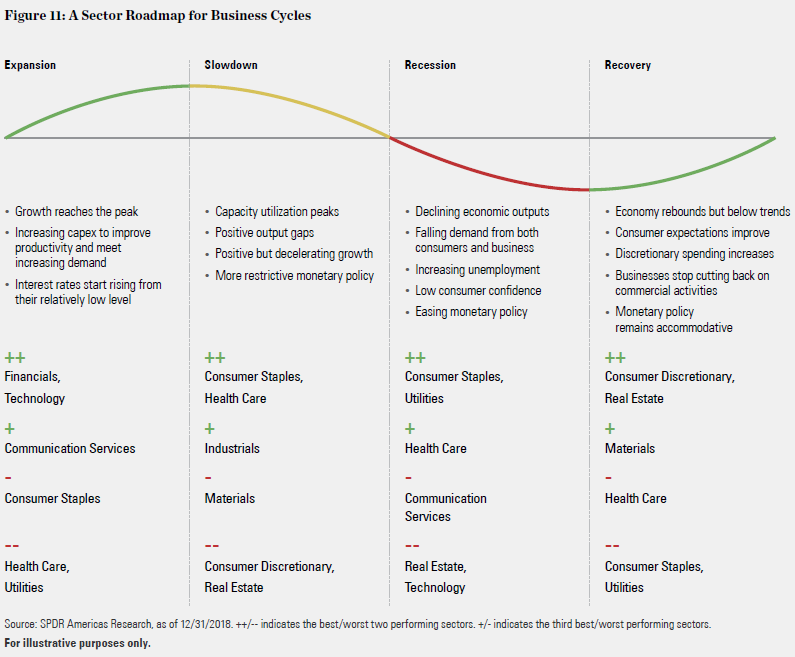

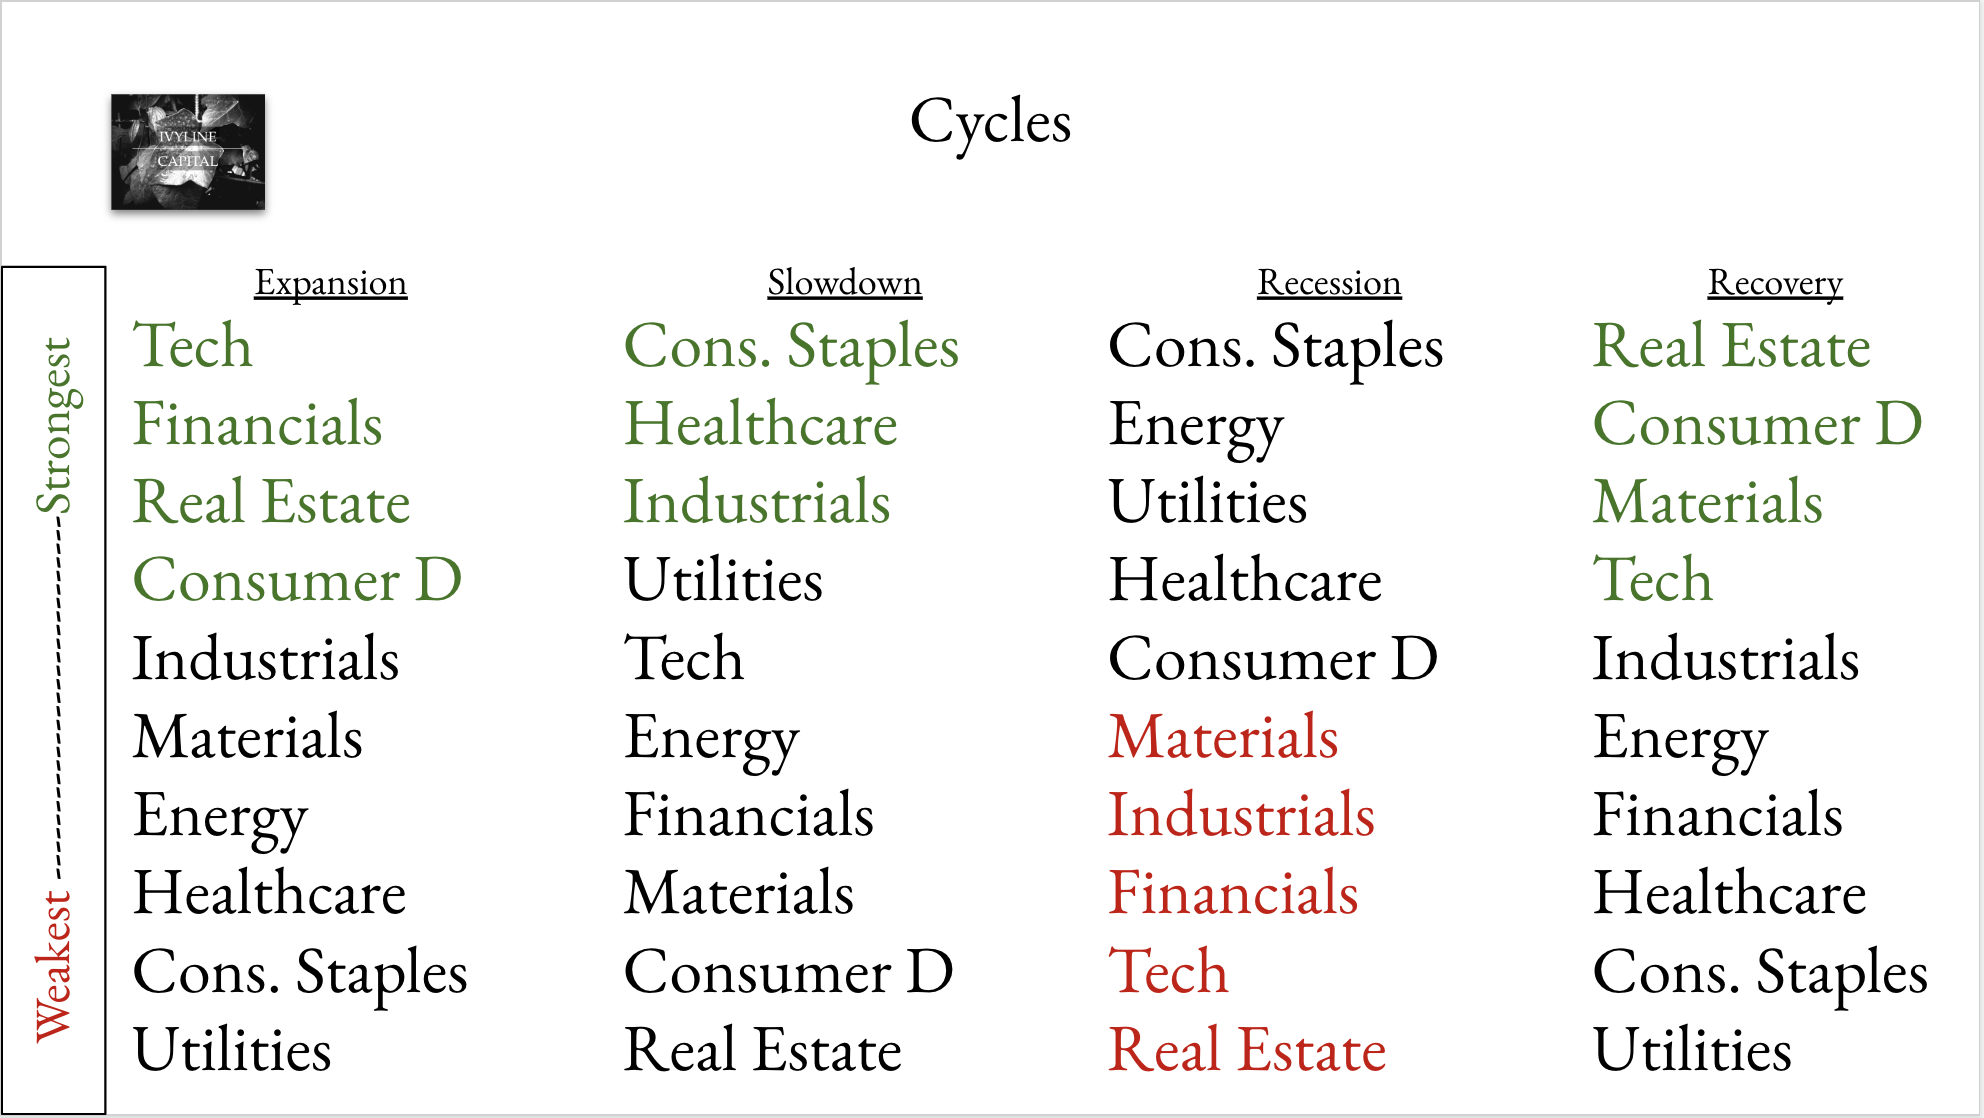

In [18]:
cycles_ = ['Expansion','Slowdown','Recession','Recovery']

path=r"C:\Users\User\Documents\wiki\wiki\dev\python\Python-Stock\reports\figures\Business cycles.png"
display(Image.open(path))
path=r"C:\Users\User\Documents\wiki\wiki\Finance\Business Cycles-2.png"
display(Image.open(path))

In [19]:
sector_performance_returned_no_dup = sector_performance_return.loc[~sector_performance_return.index.duplicated(keep ='first')]
sector_performance_return_pvt = sector_performance_returned_no_dup[sector_performance_returned_no_dup.iloc[-1].sort_values(ascending=False).index]

sector_performance_return_pvt_heatmap = sector_performance_return_pvt.style.background_gradient(cmap = cm,axis=None)
display(sector_performance_return_pvt_heatmap)

sector_performances = pd.DataFrame()
sector_performances_values = pd.DataFrame()
for c in sector_performance_returned_no_dup.T.columns:
    #print(c)
    temp = pd.DataFrame(sector_performance_returned_no_dup.T[c].sort_values(ascending=False).index,columns=[c])
    #print(temp)
    temp2 = pd.DataFrame(sector_performance_returned_no_dup.T[c].sort_values(ascending=False),columns=[c])
    #print(temp2)
    temp2.reset_index(drop=True,inplace=True)    
    sector_performances = pd.concat([sector_performances,temp],axis=1)
    sector_performances_values = pd.concat([sector_performances_values,temp2],axis=1)
    
A = sector_performances_values
B = sector_performance_returned_no_dup.T

df = B.style.apply(b_g,cmap='RdYlGn')

display(df)


,Consumer Staples ETF,Utilities ETF,Energy ETF,Health Care ETF,SP600,Real Estate ETF,Industrials ETF,SP1500,SP500,Financials ETF,Materials ETF,SP400,Information Technology ETF,Communication Services ETF,Consumer Discretionary ETF
2017-03-31 00:00:00,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2017-06-30 00:00:00,0.010040,0.022113,-0.078709,0.072895,0.018327,0.017375,0.042167,0.030375,0.030708,0.038955,0.026999,0.031752,0.041388,-0.024136,0.028386
2017-09-30 00:00:00,-0.012346,0.031518,0.069612,0.040565,0.064962,0.008095,0.052781,0.044807,0.045666,0.052789,0.066617,0.035020,0.083223,0.015498,0.014521
2017-12-31 00:00:00,0.059268,0.000687,0.073946,0.018576,0.038747,0.012742,0.066175,0.066880,0.069917,0.073683,0.071798,0.074139,0.093087,0.000763,0.097848
2018-03-31 00:00:00,-0.073521,-0.033734,-0.078807,-0.020049,-0.011631,-0.086159,-0.033542,-0.021321,-0.024130,-0.015065,-0.072483,-0.003978,0.020711,-0.085669,-0.001942
2018-06-30 00:00:00,0.006353,0.053422,0.150528,0.055259,0.106722,0.094633,-0.008057,0.052094,0.047568,-0.011331,0.036210,0.045520,0.080437,0.035862,0.088528
2018-09-30 00:00:00,0.050064,0.019751,0.021911,0.137698,0.032842,0.000044,0.094874,0.070536,0.078236,0.031675,0.007338,0.032902,0.117719,0.023115,0.066008
2018-12-31 00:00:00,-0.055862,0.009925,-0.267451,-0.108129,-0.193040,-0.058855,-0.183620,-0.142834,-0.137319,-0.138848,-0.154310,-0.172165,-0.174415,-0.143117,-0.162070
2019-03-31 00:00:00,0.111156,0.103055,0.178564,0.081835,0.124660,0.173365,0.183161,0.151853,0.144236,0.109942,0.126958,0.157497,0.217473,0.139541,0.157197
2019-06-30 00:00:00,0.036556,0.035855,-0.048754,0.017469,0.010843,0.015389,0.034436,0.039106,0.040369,0.067026,0.040951,0.030815,0.054745,0.035928,0.040127


,2017-03-31 00:00:00,2017-06-30 00:00:00,2017-09-30 00:00:00,2017-12-31 00:00:00,2018-03-31 00:00:00,2018-06-30 00:00:00,2018-09-30 00:00:00,2018-12-31 00:00:00,2019-03-31 00:00:00,2019-06-30 00:00:00,2019-09-30 00:00:00,2019-12-31 00:00:00,2020-03-31 00:00:00,2020-06-30 00:00:00,2020-09-30 00:00:00,2020-12-31 00:00:00,2021-03-31 00:00:00,2021-06-30 00:00:00,2021-09-30 00:00:00,2021-12-31 00:00:00,2022-03-31 00:00:00,2022-06-30 00:00:00
SP1500,nan,0.030375,0.044807,0.066880,-0.021321,0.052094,0.070536,-0.142834,0.151853,0.039106,0.006291,0.090490,-0.205302,0.206715,0.086119,0.132216,0.070761,0.080495,0.000378,0.103038,-0.049102,-0.163728
SP500,nan,0.030708,0.045666,0.069917,-0.024130,0.047568,0.078236,-0.137319,0.144236,0.040369,0.011423,0.089876,-0.194477,0.201618,0.090383,0.121185,0.063518,0.083593,0.002523,0.106772,-0.049099,-0.164711
SP600,nan,0.018327,0.064962,0.038747,-0.011631,0.106722,0.032842,-0.193040,0.124660,0.010843,-0.004200,0.082573,-0.328050,0.223617,0.032878,0.312278,0.184526,0.043034,-0.030694,0.049293,-0.058344,-0.144536
SP400,nan,0.031752,0.035020,0.074139,-0.003978,0.045520,0.032902,-0.172165,0.157497,0.030815,-0.009122,0.066590,-0.247693,0.259149,0.068091,0.211458,0.084662,0.033635,-0.024123,0.077726,-0.089783,-0.178547
Communication Services ETF,nan,-0.024136,0.015498,0.000763,-0.085669,0.035862,0.023115,-0.143117,0.139541,0.035928,-0.002023,0.086727,-0.187109,0.224230,0.097573,0.182130,0.083288,0.108092,-0.021207,-0.037011,-0.114414,-0.216743
Consumer Discretionary ETF,nan,0.028386,0.014521,0.097848,-0.001942,0.088528,0.066008,-0.162070,0.157197,0.040127,0.002509,0.056223,-0.231167,0.379795,0.192380,0.172875,0.073815,0.064435,-0.012866,0.099010,-0.103975,-0.254816
Consumer Staples ETF,nan,0.010040,-0.012346,0.059268,-0.073521,0.006353,0.050064,-0.055862,0.111156,0.036556,0.056319,0.036517,-0.141472,0.094561,0.098022,0.074374,0.030385,0.029888,-0.018026,0.115277,-0.019862,-0.053953
Energy ETF,nan,-0.078709,0.069612,0.073946,-0.078807,0.150528,0.021911,-0.267451,0.178564,-0.048754,-0.075658,0.054552,-0.523877,0.332245,-0.188315,0.300830,0.324479,0.126094,-0.026222,0.050203,0.379204,-0.070721
Financials ETF,nan,0.038955,0.052789,0.073683,-0.015065,-0.011331,0.031675,-0.138848,0.109942,0.067026,0.013235,0.096390,-0.330709,0.135641,0.028859,0.253698,0.165207,0.074954,0.024323,0.042310,-0.032929,-0.173466
Health Care ETF,nan,0.072895,0.040565,0.018576,-0.020049,0.055259,0.137698,-0.108129,0.081835,0.017469,-0.035439,0.147851,-0.131539,0.164463,0.062281,0.101111,0.025327,0.083442,0.000121,0.077925,-0.045192,-0.074220


In [20]:
"""
#cm = sns.color_palette("blend:red,yellow,green", as_cmap=True)
#pd.crosstab(shares_viz['Year'], shares_viz['Month'])

#seasonal_indexes[si]
seasonally_adjusted = pd.DataFrame()

for s in sector_performance_return.columns:
    
    s_ = pd.DataFrame(sector_performance_return[s])
    #print(sector_performance_return[s])
    years = []
    quarters = []
    
    for d in s_.index:
        d_ = d.strftime('%Y-%m-%d')
        #print(d_)

        datem = dt.datetime.strptime(d_, "%Y-%m-%d")
        years.append(str(datem.year))
        #print(datem.year)       # 2021
        m = datem.month
        d = datem.day
        if(len(str(m))==1):
            m = '0'+str(m)
        else:
            m = str(m)
        if(len(str(d))==1):
            d = '0'+str(d)
        else:
            d = str(d)
        quarters.append(m+"-"+d)
        
    s_['Quarter'] = quarters
    si_ = seasonal_indexes.loc[s]
    
    modified = pd.DataFrame()
    #print(si_.index)
    for s_i_ in si_.index:
        #print(s_i_)
        #when it finds the last date (which hopefully isn't a quarter date)
        if(np.sum(np.array(si)==s_i_)==0):
            #print("don't modify")
            #print(s_i_)
            match = []
            for entry in si:
                if(int(s_i_.rsplit("-")[0])<=int(entry.rsplit("-")[0])):
                    match = entry
                    break            

            delta_months = int(match.rsplit("-")[0])-int(s_i_.rsplit("-")[0])
            delta_days_ = int(match.rsplit("-")[1])-int(s_i_.rsplit("-")[1])
            
            delta_days = int(delta_months*(91.25/3)+delta_days_)
            #daily interest
            
            #print(delta_days)
            #print(seasonal_indexes.loc[s].loc[match])
            seasonal_index_to_daily = (1+seasonal_indexes.loc[s].loc[match])**(1/91.25)-1
            #print("Seasonal Index to Daily Discounted Interest Rate:",seasonal_index_to_daily)
            daily_extrapolated = (1+seasonal_index_to_daily)**delta_days-1
            #print(daily_extrapolated)
            #print("Daily ^ delta_days:",daily_extrapolated)
            
            #print(match)
            #print(s_i_)
            seasonally_adjusted_column = pd.DataFrame([seasonal_indexes.loc[s].loc[match] - daily_extrapolated],columns=[s],index=[s_.index[-1]])
            
            
        else:
            seasonally_adjusted_column = pd.DataFrame(s_[s][s_['Quarter']==s_i_] - seasonal_indexes.loc[s].loc[s_i_],columns=[s])
        modified = pd.concat([modified,seasonally_adjusted_column],axis=0)
        modified.sort_index(inplace=True)
    #print(modified)
    seasonally_adjusted = pd.concat([seasonally_adjusted,modified],axis=1)

print("Comparative to Seasonal Indexes, tells you who is over or underperforming.")
print("This is Seasonal Index - Extrapolated Current Quarter.")
print("+: seasonal > current")
print("-: current > seasonal")

print("Note if the final data in the prices ends on a quarter, this will aggregate into the seasonal_index above and there will be no comparison")
    
    
std_indexes_seas_adj = pd.DataFrame()
seasonal_indexes_seas_adj = pd.DataFrame()

temp_ = pd.DataFrame(seasonally_adjusted.T.iloc[:,-1])
temp_.columns = pd.DataFrame(seasonally_adjusted.T.iloc[:,-1]).columns.strftime('%Y-%m-%d')
display(temp_.sort_values(by=temp_.columns[0],ascending=False).style.background_gradient(cmap = cm,axis=0))

#display(seasonally_adjusted[seasonally_adjusted.columns.difference(si)].style.background_gradient(cmap = cm,axis=0))

for spr in seasonally_adjusted.columns:
    #print(spr)
    s = seasonally_adjusted[[spr]]
    #print(s)
    years = []
    quarters = []
    for d in seasonally_adjusted[spr].index:
        d_ = d.strftime('%Y-%m-%d')
        #print(d_)

        datem = dt.datetime.strptime(d_, "%Y-%m-%d")
        years.append(str(datem.year))
        #print(datem.year)       # 2021
        m = datem.month
        d = datem.day
        if(len(str(m))==1):
            m = '0'+str(m)
        else:
            m = str(m)
        if(len(str(d))==1):
            d = '0'+str(d)
        else:
            d = str(d)
        quarters.append(m+"-"+d)

    s['Years'] = years
    s['Quarters'] = quarters
    ct = pd.crosstab(s['Years'], s['Quarters'],values=s[spr],aggfunc=np.mean).mean(axis=0).sort_index()
    ct.columns = [spr]
    #print(ct)
    
    ct_std = pd.crosstab(s['Years'], s['Quarters'],values=s[spr],aggfunc=np.mean).std(axis=0).sort_index()
    ct_std.columns = [spr]
    
    std_indexes_seas_adj = pd.concat([std_indexes_seas_adj,ct_std],axis=1)
    seasonal_indexes_seas_adj = pd.concat([seasonal_indexes_seas_adj,ct],axis=1)

seasonal_indexes_seas_adj.columns = seasonally_adjusted.columns

std_indexes_seas_adj.columns = seasonally_adjusted.columns
    
seasonal_indexes_seas_adj = seasonal_indexes_seas_adj.T

std_indexes_seas_adj = std_indexes_seas_adj.T

sector_performances_sea_adj = pd.DataFrame()
sector_performances_values_sea_adj = pd.DataFrame()
for c in seasonally_adjusted.T.columns:
    temp = pd.DataFrame(seasonally_adjusted.T[c].sort_values(ascending=False).index,columns=[c])
    temp2 = pd.DataFrame(seasonally_adjusted.T[c].sort_values(ascending=False),columns=[c])
    temp2.reset_index(drop=True,inplace=True)    
    sector_performances_sea_adj = pd.concat([sector_performances_sea_adj,temp],axis=1)
    sector_performances_values_sea_adj = pd.concat([sector_performances_values_sea_adj,temp2],axis=1)

A = sector_performances_values_sea_adj
B = sector_performances_sea_adj

df_sea_adj = B.style.apply(b_g,cmap='RdYlGn')
display(df_sea_adj)
"""

'\n#cm = sns.color_palette("blend:red,yellow,green", as_cmap=True)\n#pd.crosstab(shares_viz[\'Year\'], shares_viz[\'Month\'])\n\n#seasonal_indexes[si]\nseasonally_adjusted = pd.DataFrame()\n\nfor s in sector_performance_return.columns:\n    \n    s_ = pd.DataFrame(sector_performance_return[s])\n    #print(sector_performance_return[s])\n    years = []\n    quarters = []\n    \n    for d in s_.index:\n        d_ = d.strftime(\'%Y-%m-%d\')\n        #print(d_)\n\n        datem = dt.datetime.strptime(d_, "%Y-%m-%d")\n        years.append(str(datem.year))\n        #print(datem.year)       # 2021\n        m = datem.month\n        d = datem.day\n        if(len(str(m))==1):\n            m = \'0\'+str(m)\n        else:\n            m = str(m)\n        if(len(str(d))==1):\n            d = \'0\'+str(d)\n        else:\n            d = str(d)\n        quarters.append(m+"-"+d)\n        \n    s_[\'Quarter\'] = quarters\n    si_ = seasonal_indexes.loc[s]\n    \n    modified = pd.DataFrame()\n    #print

In [21]:
"""
index_performance = []
for v in indexes['Symbol'].values:
    index_performance.append([v,screener.loc[v]['risk_trend_factor']])
temp_i = pd.DataFrame(index_performance,index=indexes.index)
temp_i.columns = ['Symbol','risk_trend_factor']
index_risk_sorted = pd.DataFrame(index_performance,columns=['Symbol','risk_trend_factor'],index=indexes.index).sort_values(by='risk_trend_factor',ascending=False).reset_index()
index_risk_sorted.columns = ['Index','Symbol','risk_trend_factor']
index_risk_sorted
"""

"\nindex_performance = []\nfor v in indexes['Symbol'].values:\n    index_performance.append([v,screener.loc[v]['risk_trend_factor']])\ntemp_i = pd.DataFrame(index_performance,index=indexes.index)\ntemp_i.columns = ['Symbol','risk_trend_factor']\nindex_risk_sorted = pd.DataFrame(index_performance,columns=['Symbol','risk_trend_factor'],index=indexes.index).sort_values(by='risk_trend_factor',ascending=False).reset_index()\nindex_risk_sorted.columns = ['Index','Symbol','risk_trend_factor']\nindex_risk_sorted\n"

In [22]:
"""
sector_performance = []
for v in sectors['Symbol'].values:
    sector_performance.append([v,screener.loc[v]['risk_trend_factor']])
temp_v = sectors.reset_index()
temp_v.columns = ['Sector','Symbol']
sectors_risk_sorted = pd.DataFrame(sector_performance,columns=['Symbol','risk_trend_factor']).merge(temp_v, on='Symbol', how='left').sort_values(by='risk_trend_factor',ascending=False)    
sectors_risk_sorted
"""

"\nsector_performance = []\nfor v in sectors['Symbol'].values:\n    sector_performance.append([v,screener.loc[v]['risk_trend_factor']])\ntemp_v = sectors.reset_index()\ntemp_v.columns = ['Sector','Symbol']\nsectors_risk_sorted = pd.DataFrame(sector_performance,columns=['Symbol','risk_trend_factor']).merge(temp_v, on='Symbol', how='left').sort_values(by='risk_trend_factor',ascending=False)    \nsectors_risk_sorted\n"

Rolling Quarterly Mean Return


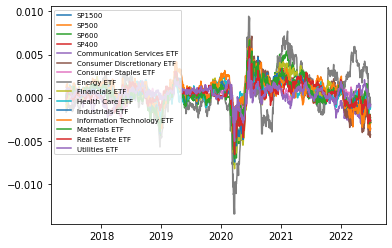

In [23]:
print("Rolling Quarterly Mean Return")
plt.plot(sector_performance_Q_smoothed_return)
plt.legend([*[i for i in indexes.index],*[v for v in sectors.index]],loc=2,fontsize=7)
plt.show()

Quarterly Returns


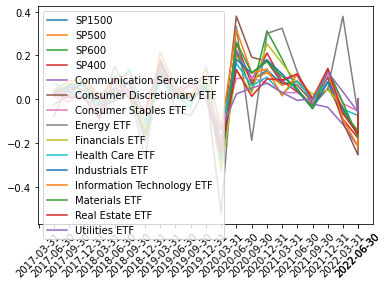

In [24]:
print ("Quarterly Returns")
for v in sector_performance_return.T.index:
    subset = pd.DataFrame(sector_performance_return.T.loc[v])
    subset.columns = ['Return']
    plt.plot(subset)
    plt.xticks(subset.index, rotation=45)
plt.legend(sector_performance_return.T.index,loc=2)    
plt.show()


In [25]:
"""
plt.plot(seasonal_indexes[si].T)
plt.legend(seasonal_indexes[si].T.columns,loc=2,fontsize=8)
plt.show()
"""

'\nplt.plot(seasonal_indexes[si].T)\nplt.legend(seasonal_indexes[si].T.columns,loc=2,fontsize=8)\nplt.show()\n'

In [26]:
#threshold = 0

In [27]:
#risk_trend_threshold

In [28]:
#market_data['sector'] = stock_fundamentals['sector']

In [29]:
#screener[['risk_trend_factor']].replace(['missing','error'], np.NaN).dropna().hist()

In [30]:
#len(screener)

In [31]:
#prices_df.columns

In [32]:
#threshold

In [33]:
#threshold_value = summary.dropna()['risk_trend_factor'].quantile([threshold])

In [34]:
screener_sorted.head(50)

,Date,MIN_Lookback_One_Year,MIN_Lookback_2_Months,MIN_Lookback_1_Months,risk_trend_factor,risk_per_share,volume_factor,Adj Close,21dBOLD,21dMA-TP,21dBOLU,90dSMA,90dSDev,adf,hurst,sector_risk_trend_factor,Sector,Sector Symbol,Market Index,Index Symbol
ACC,2022-06-30 00:00:00,49.209999,65.019997,65.129997,10.181159,1.380001,1.959881,64.470001,64.012593,64.567897,65.123201,63.341746,2.877104,0.97806,0.426072,-3.795964,Real Estate,VNQ,SP400,MDYG
MTOR,2022-06-30 00:00:00,32.93,36.279999,36.299999,6.960014,0.5,1.563578,36.330002,35.950398,36.118135,36.285871,35.976508,0.209317,0.357486,0.437983,-6.245972,Consumer Cyclical,VCR,SP600,SLY
PSB,2022-06-30 00:00:00,165.850006,189.830002,189.830002,5.652488,2.819992,2.063846,187.149994,185.666536,186.570769,187.475003,181.461531,8.467314,0.849823,0.479662,-3.795964,Real Estate,VNQ,SP400,MDYG
Y,2022-06-30 00:00:00,737.890015,862.869995,862.869995,3.754729,9.5,1.608517,833.099976,829.643853,832.784718,835.925583,836.358292,6.423031,0.460673,0.462641,error,error,error,SP400,MDYG
TVTY,2022-06-30 00:00:00,27.870001,32.889999,32.889999,3.195021,1.205,1.881193,32.5,31.852152,32.262421,32.672689,32.181865,0.232209,0.527586,0.448045,error,error,error,SP600,SLY
FCN,2022-06-30 00:00:00,147.380005,170.309998,170.809998,2.393712,22.580002,0.888189,180.850006,159.043358,168.987342,178.931325,165.012341,5.295496,0.964867,0.402816,-4.944887,Industrials,VIS,SP400,MDYG
MCK,2022-06-30 00:00:00,204.660004,335.600006,339.940002,2.386181,41.25,1.14652,326.209991,299.296342,314.21127,329.126197,319.45818,8.866643,0.998802,0.460192,-2.917288,Healthcare,VHT,SP500,SPY
LLY,2022-06-30 00:00:00,239.369995,314.0,324.079987,1.990387,47.850006,0.979007,324.230011,281.421935,305.631587,329.841239,300.098888,11.494457,0.99589,0.405718,-2.917288,Healthcare,VHT,SP500,SPY
BANF,2022-06-30 00:00:00,77.379997,86.82,92.870003,1.512833,19.870003,1.581506,95.709999,89.987747,94.094841,98.201935,87.412341,5.323816,0.960056,0.537106,-5.390992,Financial Services,VFH,SP600,SLY
GCP,2022-06-30 00:00:00,27.780001,32.279999,32.279999,1.507543,0.994999,2.06458,31.280001,30.836022,31.142449,31.448875,31.163254,0.225323,0.170195,0.45352,-3.29476,Basic Materials,VAW,SP600,SLY


In [35]:
#completed_fred_pvt_df = completed_fred_pvt.asfreq('D').reindex(nyse_dates.index).interpolate(method='time')
completed_fred_pvt_df = completed_fred_pvt

temp_new = completed_fred_pvt.asfreq('D').interpolate(method='time',limit_area='inside').reindex(nyse_dates.index)
temp_dates = pd.date_range(completed_fred_pvt.index[0].strftime('%Y-%m-%d'), completed_fred_pvt.index[-1].strftime('%Y-%m-%d'), freq='D').map(lambda t: t.strftime('%Y-%m-%d'))
nyse_inbetween_temp_dates = nyse_dates.index[(nyse_dates.index >= temp_dates[0]) & (nyse_dates.index <= temp_dates[-1])]
temp_new = temp_new.reindex(nyse_inbetween_temp_dates)

completed_fred_pvt_df = temp_new
completed_fred_pvt_df.columns = [name[1] for name in completed_fred_pvt_df.columns]

In [36]:
np.array(completed_fred_pvt_df.index.map(lambda t: t.strftime('%Y-%m-%d')))[np.arange(0,len(completed_fred_pvt_df.index),int(len(completed_fred_pvt_df.index)/10))]

array(['2017-03-01', '2017-09-11', '2018-03-23', '2018-10-03',
       '2019-04-17', '2019-10-28', '2020-05-11', '2020-11-18',
       '2021-06-03', '2021-12-13', '2022-06-24'], dtype=object)

nominal, pct_change, pct_change().cumsum
Average Weekly Hours


C:\Users\User\AppData\Local\Temp\ipykernel_8636\1706258090.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(np.array(completed_fred_pvt_df.index.map(lambda t: t.strftime('%Y-%m-%d')))[np.arange(0,len(completed_fred_pvt_df.index),int(len(completed_fred_pvt_df.index)/10))], rotation=45)
C:\Users\User\AppData\Local\Temp\ipykernel_8636\1706258090.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(np.array(completed_fred_pvt_df.index.map(lambda t: t.strftime('%Y-%m-%d')))[np.arange(0,len(completed_fred_pvt_df.index),int(len(completed_fred_pvt_df.index)/10))], rotation=45)
C:\Users\User\AppData\Local\Temp\ipykernel_8636\1706258090.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax3.set_xticklabels(np.array(completed_fred_pvt_df.index.map(lambda t: t.strftime('%Y-%m-%d')))[np.arange(0,len(completed_fred_pvt_df.index),int(len(completed_fred_pvt_df.inde

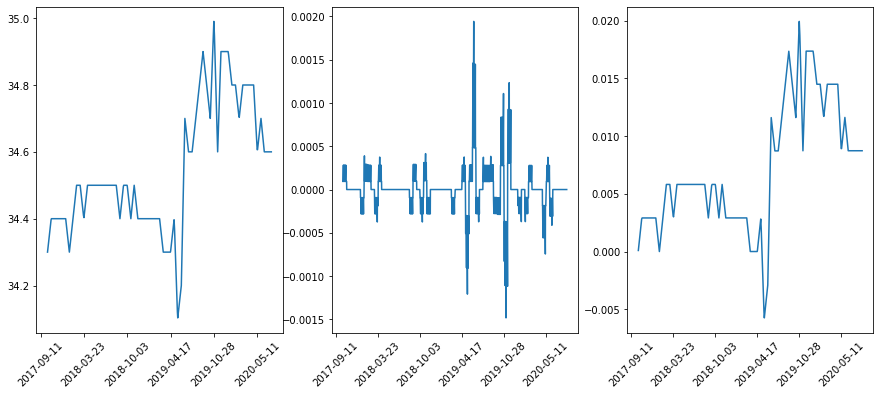

Market volatility


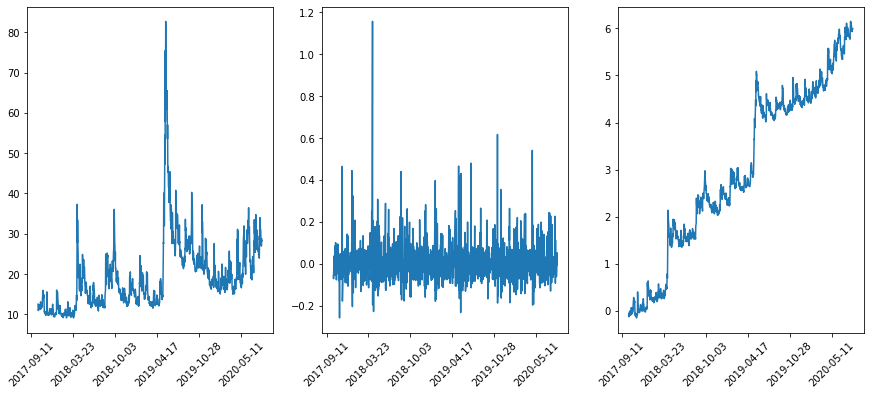

Consumer Confidence


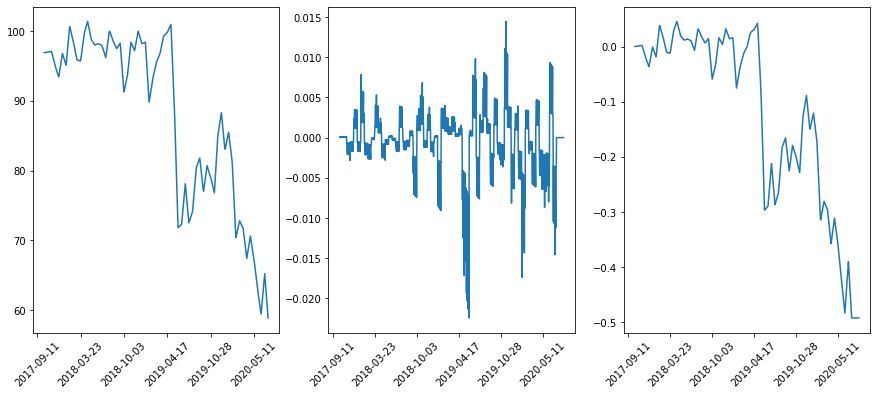

Unemployment


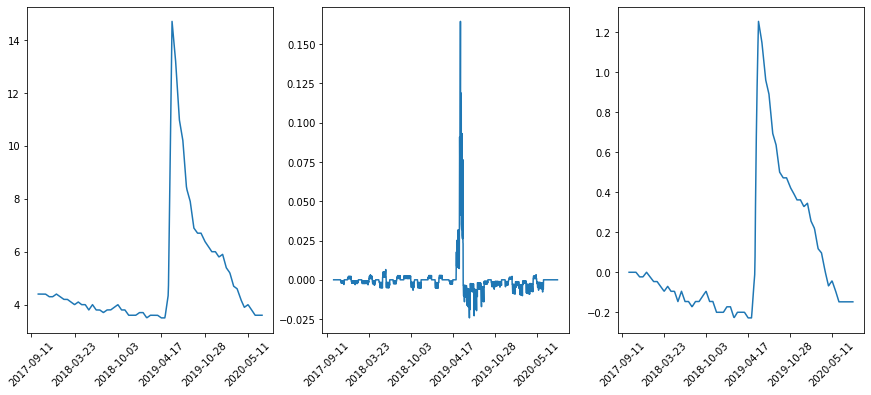

Mfr Orders Excl AC


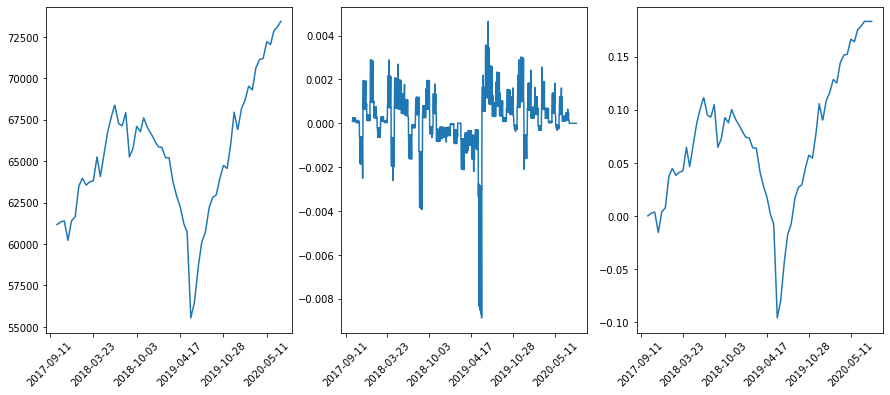

Oil Prices


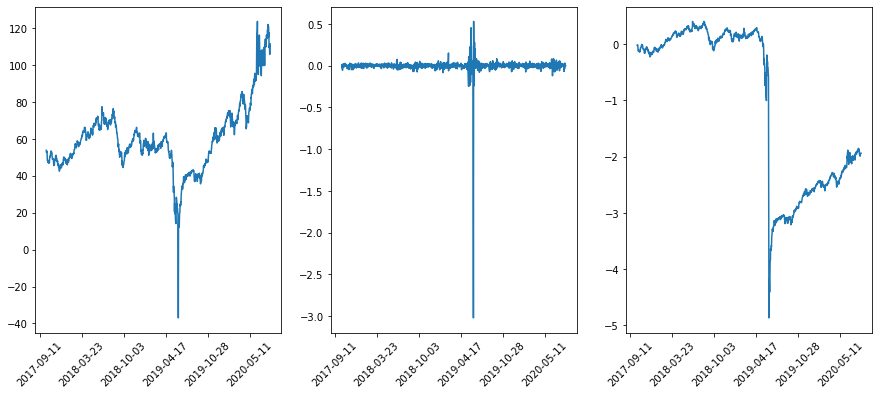

Inflation


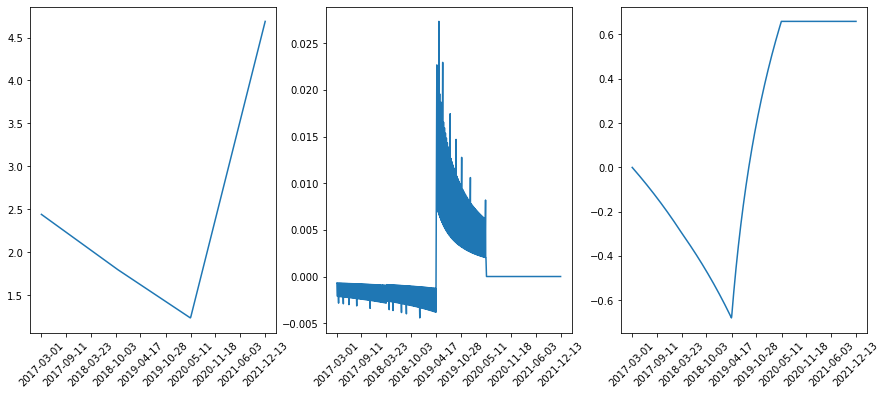

Housing Prices


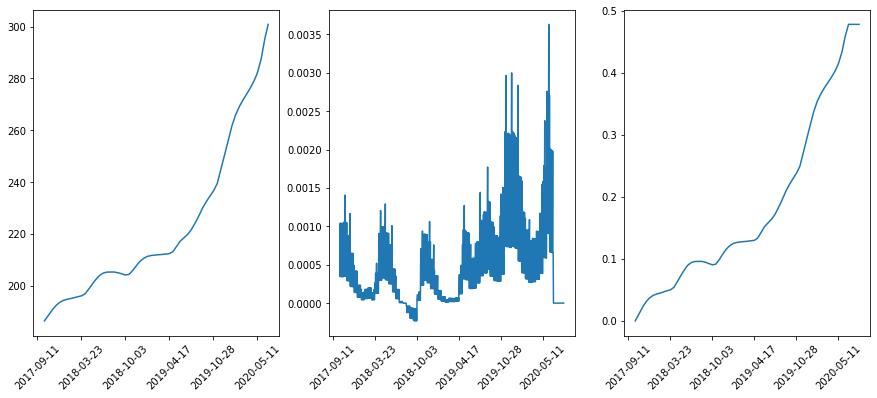

Interest Rates


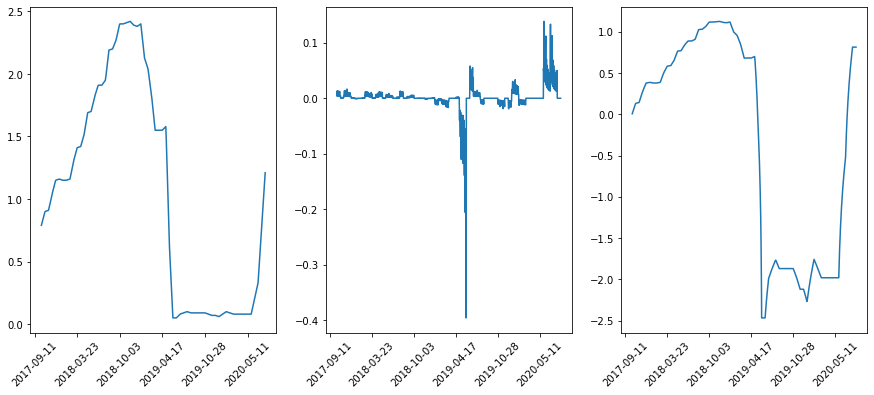

10 Year to 3 Month


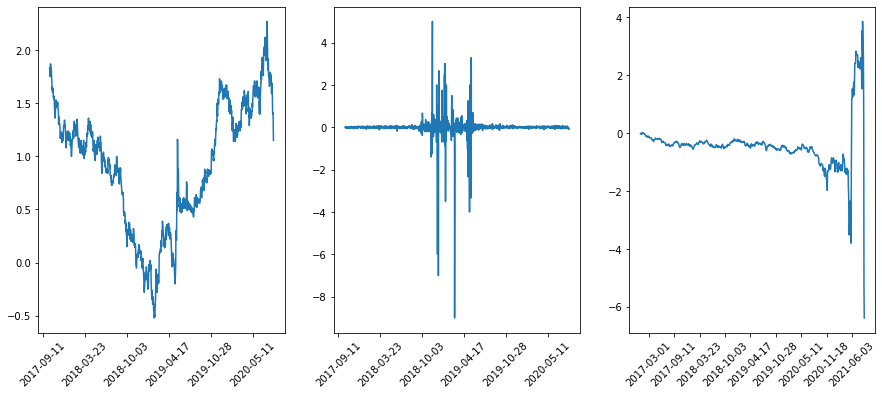

Recession Indicator


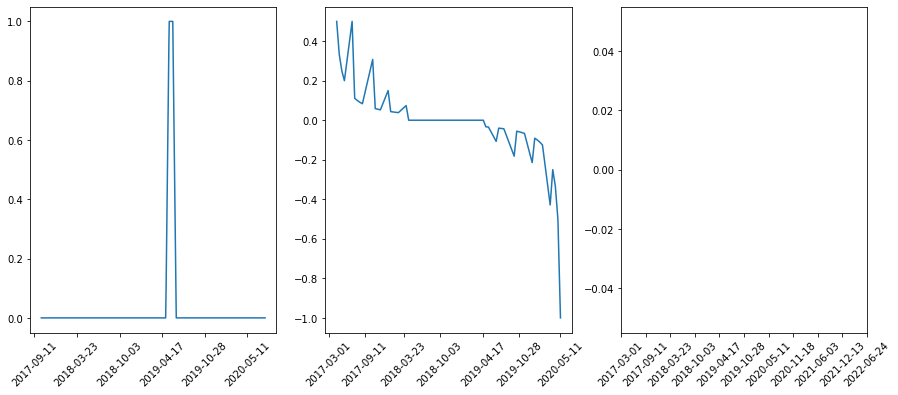

OECD Leading Indicator


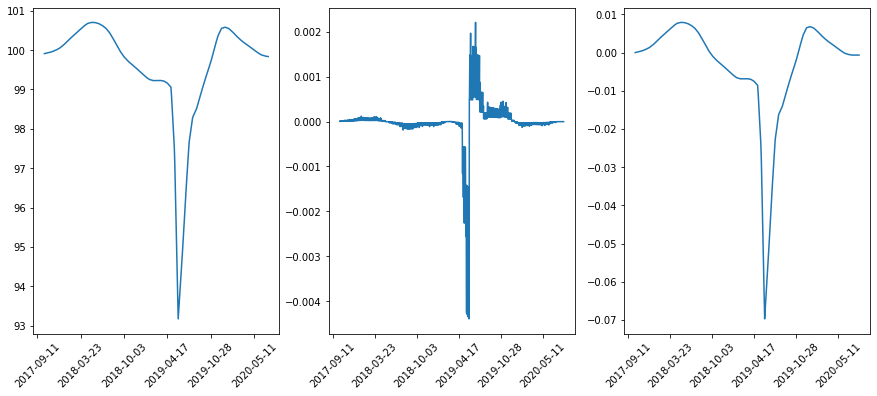

Coincident Index


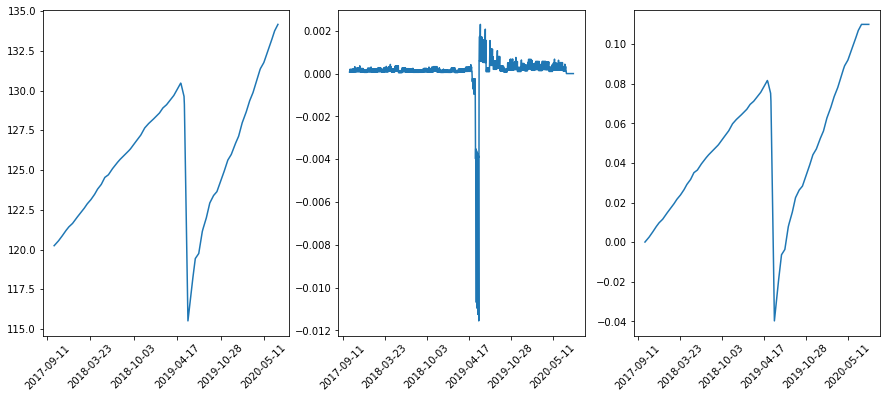

In [37]:
#fred_friendly_names = ['Personal Expenditures','Average Weekly Hours','Market volatility','Consumer Confidence','Unemployment','Mfr Orders Excl AC','Oil Prices','Inflation','Housing Prices','Interest Rates','10 Year to 3 Month','Recession Indicator','OECD Leading Indicator','Coincident Index']
#fred_names = ['PCE','AWHAETP','VIXCLS','UMCSENT','UNRATE','NEWORDER','DCOILWTICO','FPCPITOTLZGUSA','CSUSHPINSA','FEDFUNDS','T10Y3M','USREC','USALOLITONOSTSAM','USPHCI']
fred_friendly_names = ['Average Weekly Hours','Market volatility','Consumer Confidence','Unemployment','Mfr Orders Excl AC','Oil Prices','Inflation','Housing Prices','Interest Rates','10 Year to 3 Month','Recession Indicator','OECD Leading Indicator','Coincident Index']
fred_names = ['AWHAETP','VIXCLS','UMCSENT','UNRATE','NEWORDER','DCOILWTICO','FPCPITOTLZGUSA','CSUSHPINSA','FEDFUNDS','T10Y3M','USREC','USALOLITONOSTSAM','USPHCI']

#fred_names = ['AWHAETP','VIXCLS','UMCSENT','UNRATE','DGORDER','DCOILWTICO','FPCPITOTLZGUSA','CSUSHPINSA','FEDFUNDS','T10Y3M','USREC','USALOLITONOSTSAM','USPHCI']
print('nominal,','pct_change,','pct_change().cumsum')
for pos in range(0,len(fred_names)):
    print(fred_friendly_names[pos])
    name = fred_names[pos]
    
    
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=False,figsize=(15,6))
    ax1.plot(completed_fred_pvt_df[name])
    ax1.set_xticklabels(np.array(completed_fred_pvt_df.index.map(lambda t: t.strftime('%Y-%m-%d')))[np.arange(0,len(completed_fred_pvt_df.index),int(len(completed_fred_pvt_df.index)/10))], rotation=45)
    ax2.plot(completed_fred_pvt_df[name].pct_change())
    ax2.set_xticklabels(np.array(completed_fred_pvt_df.index.map(lambda t: t.strftime('%Y-%m-%d')))[np.arange(0,len(completed_fred_pvt_df.index),int(len(completed_fred_pvt_df.index)/10))], rotation=45)
    ax3.plot(completed_fred_pvt_df[name].pct_change().cumsum())
    ax3.set_xticklabels(np.array(completed_fred_pvt_df.index.map(lambda t: t.strftime('%Y-%m-%d')))[np.arange(0,len(completed_fred_pvt_df.index),int(len(completed_fred_pvt_df.index)/10))], rotation=45)
    plt.show()

In [38]:
#screener['vol_30d_2yr']

In [39]:
#pd.DataFrame(np.mean(np.exp(final_model.get_prediction(start=end,end=(end + dt.timedelta(92)).strftime('%Y-%m-%d')).summary_frame())[['mean','pi_lower']],axis=1)).iloc[0].values[0]
#[s,e_return,s_date,stop_loss_price,days_delta,discounted_return,qtr_return,test_score_mean,test_score_std,mean_revert_flag,p_metrics['pi_lower'].values[0],p_metrics['pi_upper'].values[0]]
#screener['Adj Close'].loc[decision_metrics_df.index]

In [40]:
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

#tscv = expanding_window(initial =52*2, horizon = 13,period = 26)

#batchClearLimit = round(len(list__)/7)

print("adf < .05 or .01, mean reverting")
print("Hurst")
print("> .5 - The time series is mean reverting.")
print("= .5 - The time series is a Geometric Brownian Motion.")
print("< .5 - The time series is trending.")
"""*indexes['Symbol'].values,*sectors['Symbol'].values,"""

widgets.Dropdown(
    #options=stocks_,
    #value=None,
    description='Choose Stock:',
    disabled=False,
)

#y_=widgets.Select(options=stocks_,disabled=False)
y_=widgets.Select(options=np.sort([*list_sector_n_indexes,*list_stocks]),value=None,disabled=False)

a=interact(plot_,symbol_=y_)


adf < .05 or .01, mean reverting
Hurst
> .5 - The time series is mean reverting.
= .5 - The time series is a Geometric Brownian Motion.
< .5 - The time series is trending.


C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\traitlets\traitlets.py:697: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  silent = bool(old_value == new_value)


interactive(children=(Select(description='symbol_', options=('A', 'AA', 'AAL', 'AAN', 'AAON', 'AAP', 'AAPL', '…